In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [2]:
raw_data = pd.read_table('usersha1-artmbid-artname-plays.tsv')

In [3]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [4]:
raw_data.head()

user                 artist  plays
0  00000c289a1829a808ac09c00daf10bc3c4e223b              die Ärzte   1099
1  00000c289a1829a808ac09c00daf10bc3c4e223b      melissa etheridge    897
2  00000c289a1829a808ac09c00daf10bc3c4e223b              elvenking    717
3  00000c289a1829a808ac09c00daf10bc3c4e223b   juliette & the licks    706
4  00000c289a1829a808ac09c00daf10bc3c4e223b  red hot chili peppers    691

In [5]:
data = raw_data.dropna()

In [6]:
data.loc[[1,2]]

user             artist  plays
1  00000c289a1829a808ac09c00daf10bc3c4e223b  melissa etheridge    897
2  00000c289a1829a808ac09c00daf10bc3c4e223b          elvenking    717

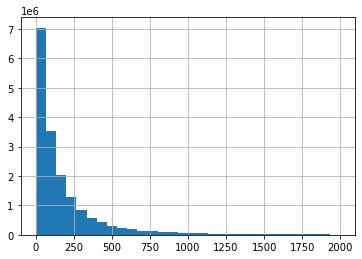

In [7]:
data.iloc[np.where(data.plays < 2000)].plays.hist(bins=30)

In [8]:
data = data.loc[data.plays != 0].reset_index(drop=True)

In [9]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

In [10]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

In [11]:
data = data.drop(['user', 'artist'], axis=1)

In [12]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

<ipython-input-12-d7e927a21f56>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(item_lookup.iterrows()):


In [13]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [14]:
users[:5]

[0, 1, 2, 3, 4]

In [15]:
artists[:5]

[0, 1, 2, 3, 4]

In [16]:
plays[:5]

[1099, 897, 717, 706, 691]

In [17]:
len(users)

358868

In [18]:
len(artists)

292363

In [19]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [20]:
data_sparse = sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))

In [21]:
data_sparse[90933,0]

0

In [22]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

C:\ProgramData\Anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


In [23]:
userid = 1111

recommendations = model.recommend(userid, data_sparse[userid])

In [24]:
', '.join([artist_id_name[str(art)] for art in data[data['user_id']==userid]['artist_id']])
    

'hateen, ihab tawfik, tarkan, foo fighters, ride, audioslave, social distortion, wael kfoury, pin ups, the draft, hot water music, mazikana_ehab_tawfik, snow patrol, jimmy eat world, damien rice, samira said, ehab tawfiq, dido, panic! at the disco, inspiral carpets, saves the day, nickelback, alkaline trio, maná, amy winehouse, baby bash, ramones, oasis, nada surf, fall out boy, fresno, garage fuzz, ashanti, johnny cash, the ataris, the beatles, goo goo dolls, the perishers, 3 doors down, mustafa amar, nxzero, new order, relient k, rbd, semisonic, street bulldogs'

In [25]:
for r in recommendations[0]:
    print(artist_id_name[str(r)])

dashboard confessional
los hermanos
green day
lifehouse
stereophonics
legião urbana
blink-182
descendents
mxpx
the cranberries


In [26]:
[(k,v) for k,v in artist_id_name.items() if 'the beatles' in v]

[('252494', 'the beatles'),
 ('252498', 'the beatles - one - cant buy me love'),
 ('4111', '52. the beatles'),
 ('1048',
  '0blo=0\t30\n1072c26dee2510f81cf0985bbcac51cd6037372f\t927dcbc3-9c46-4833-8173-b76e785a4b75\tДельфин\t29\n1072c26dee2510f81cf0985bbcac51cd6037372f\t01e10b31-ae0f-49a6-b4f4-5c3dcff9788a\tНочные Снайперы\t29\n1072c26dee2510f81cf0985bbcac51cd6037372f\t4f7ba8a3-35c2-4225-a38b-bf3bc7294cf6\tАдриан и Александр\t26\n1072c26dee2510f81cf0985bbcac51cd6037372f\t990c9ba3-a793-4d27-8167-1d9b96c6b1d7\tИгорь Вдовин\t26\n1072c26dee2510f81cf0985bbcac51cd6037372f\tdfe9a7c4-8cf2-47f4-9dcb-d233c2b86ec3\tamy winehouse\t24\n1072c26dee2510f81cf0985bbcac51cd6037372f\t66cc244d-6f96-4668-a6e9-0f9cd5acc940\tgotan project\t23\n1072c26dee2510f81cf0985bbcac51cd6037372f\tc4b87e45-c07a-460f-9c58-8d15328e2964\tsophie ellis-bextor\t22\n1072c26dee2510f81cf0985bbcac51cd6037372f\t92569dea-79aa-40f3-93ca-9642b6fb75ed\tМультfильмы\t22\n1072c26dee2510f81cf0985bbcac51cd6037372f\tf91b9b28-25b7-4064-81d1-f4

In [27]:
itemid = 252494
related = model.similar_items(itemid)

In [28]:
artist_id_name[str(itemid)]

'the beatles'

In [29]:
for a in related[0]:
    print(artist_id_name[str(a)])

the beatles
pink floyd
radiohead
coldplay
muse
red hot chili peppers
nirvana
the cure
the smashing pumpkins
led zeppelin
